# DNN Model

## Imports

In [28]:
use_google_drive = False

try:
  import google.colab
  from google.colab import drive
  !pip install webdataset kornia optuna
  use_google_drive = True
except Exception:
  pass


In [13]:
import shutil
import torch
import time
import kornia
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import numpy as np
import torch
import webdataset as wds
from torchvision import transforms

from IPython.display import display, HTML
from jinja2 import Environment

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report


import optuna
from optuna.samplers import TPESampler,GridSampler
import torch.optim as optim

## Definitions and Parameters

In [14]:
dataset_id = 4
no_multicolor = True #not used when dataset_id==5
model_name = "alexnet" #resnet18, vgg11_bn
color_space = 'rgb' #rgb, hsl, or hsv
epoch_round = 120

learning_rate = 0.00007
dropout = 0.1
batch_size = 32

optimization_mode=True

In [15]:
if use_google_drive:
  model_save_file = f"/content/gdrive/MyDrive/ColabData/amazon/shoes-model-{dataset_id}-{'singlecolor' if no_multicolor else 'multicolor'}-{color_space}.model"
  training_dataset_file = f"file:///content/gdrive/MyDrive/ColabData/amazon/shoes-224-training-{dataset_id}.tar"
  validation_dataset_file = f"file:///content/gdrive/MyDrive/ColabData/amazon/shoes-224-validation-{dataset_id}.tar"
  test_dataset_file = f"file:///content/gdrive/MyDrive/ColabData/amazon/shoes-224-test-{dataset_id}.tar"
  report_folder = f"/content/gdrive/MyDrive/ColabData/amazon/report/dataset-{dataset_id}/cnn-{'singlecolor' if no_multicolor else 'multicolor'}-{color_space}"
  optuna_save_file = f"/content/gdrive/MyDrive/ColabData/amazon/shoes-optuna-{dataset_id}-{'singlecolor' if no_multicolor else 'multicolor'}-{color_space}.db"

  drive.mount("/content/gdrive")
else:
  model_save_file = f"model\\shoes-model-{dataset_id}-{'singlecolor' if no_multicolor else 'multicolor'}-{color_space}.model"
  training_dataset_file = f"file://{os.getcwd()}/dataset/shoes-224-training-{dataset_id}.tar".replace('\\', '/')
  validation_dataset_file = f"file://{os.getcwd()}/dataset/shoes-224-validation-{dataset_id}.tar".replace('\\', '/')
  test_dataset_file = f"file://{os.getcwd()}/dataset/shoes-224-test-{dataset_id}.tar".replace('\\', '/')
  report_folder = f"./report/dataset-{dataset_id}/cnn-{'singlecolor' if no_multicolor else 'multicolor'}-{color_space}"
  optuna_save_file = f"model\\shoes-optuna-{dataset_id}-{'singlecolor' if no_multicolor else 'multicolor'}-{color_space}.db"

device = "cuda" if torch.cuda.is_available() else "cpu"


In [16]:
#copy to local folder to speed up

if use_google_drive:
  shutil.copyfile(training_dataset_file.replace("file://", ""), f"/content/shoes-224-training-{dataset_id}.tar")
  shutil.copyfile(validation_dataset_file.replace("file://", ""), f"/content/shoes-224-validation-{dataset_id}.tar")
  shutil.copyfile(test_dataset_file.replace("file://", ""), f"/content/shoes-224-test-{dataset_id}.tar")

  training_dataset_file = f"file:///content/shoes-224-training-{dataset_id}.tar".replace('\\', '/')
  validation_dataset_file = f"file:///content/shoes-224-validation-{dataset_id}.tar".replace('\\', '/')
  test_dataset_file = f"file:///content/shoes-224-test-{dataset_id}.tar".replace('\\', '/')


## Helper Functions

In [17]:
class ConvertColorSpace(object):
  def __init__(self, source_colorspace='rgb', target_colorspace='hsl'):
    self.source_colorspace = source_colorspace
    self.target_colorspace = target_colorspace

  def __call__(self, input: torch.Tensor):
    if self.source_colorspace == self.target_colorspace:
      return input
    elif self.source_colorspace == 'rgb' and self.target_colorspace == 'hsl':
      hls = kornia.color.rgb_to_hls(input)
      return torch.cat((hls[0, :, :], hls[2, :, :], hls[1, :, :])).reshape(input.shape)
    elif self.source_colorspace == 'rgb' and self.target_colorspace == 'hsv':
      return kornia.color.rgb_to_hsv(input)
    elif self.source_colorspace == 'hsl' and self.target_colorspace == 'rgb':
      hls = torch.cat((input[0, :, :], input[2, :, :], input[1, :, :])).reshape(input.shape)
      return kornia.color.hls_to_rgb(hls)
    elif self.source_colorspace == 'hsv' and self.target_colorspace == 'rgb':
      return kornia.color.hsv_to_rgb(input)
    else:
      raise Exception(f"Unsupported color space {self.target_colorspace}")

  def __repr__(self):
    return self.__class__.__name__


In [18]:
# Helper for visualization
def torch_imshow(img):
  img = ConvertColorSpace(source_colorspace=color_space, target_colorspace='rgb')(img)
  img = np.clip(img, 0, 1)
  img = img.permute(1, 2, 0)
  plt.imshow(img.cpu().numpy())
  plt.show()


In [19]:
classes = []

if dataset_id != 5:
  classes = ["black", "white", "gray", "red", "green", "blue", "orange", "purple", "yellow", "pink", "brown", "multicolor"]
else:
  classes = ["invalid", "valid"]

def fromcls(cls):
  return classes[cls]

def tocls(cls):
  if cls in classes:
    return classes.index(cls)
  else:
    return None


## Load Dataset

black


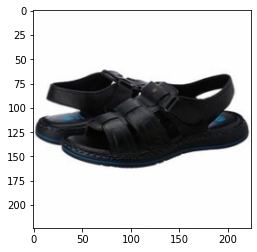

In [20]:
preproc = transforms.Compose([
    transforms.ToTensor(),
    ConvertColorSpace(source_colorspace='rgb', target_colorspace=color_space)
])


training_dataset = (wds.WebDataset(training_dataset_file)
                    .select(predicate=lambda r: not no_multicolor or int(r["cls"]) != 11)
                    .decode("pil", only="jpg")
                    .to_tuple("jpg", "cls")
                    .map_tuple(preproc, lambda a: int(a))
                    .shuffle(100)
                    )

validation_dataset = (wds.WebDataset(validation_dataset_file)
                      .select(predicate=lambda r: not no_multicolor or int(r["cls"]) != 11)
                      .decode("pil", only="jpg")
                      .to_tuple("jpg", "cls")
                      .map_tuple(preproc, lambda a: int(a))
                      .shuffle(100)
                      )

test_dataset = (wds.WebDataset(test_dataset_file)
                .select(predicate=lambda r: not no_multicolor or int(r["cls"]) != 11)
                .decode("pil", only="jpg")
                .to_tuple("jpg", "cls")
                .map_tuple(preproc, lambda a: int(a))
                .shuffle(100)
                )

for jpg, cls in training_dataset:
  break

print(classes[cls])
torch_imshow(jpg)


## Model Helper Functions

In [22]:
def check_accuracy(neuralnet, dataloader, show_matrix=False, show_report=False, save_matrix=None):
  neuralnet.eval()

  y = []
  y_hat = []

  with torch.no_grad():

    for imgs_batch, labels_batch in dataloader:
      imgs_batch, labels_batch = imgs_batch.to(device), labels_batch.to(device)

      output = neuralnet(imgs_batch)

      y_hat.append(output.argmax(dim=1).cpu().numpy())
      y.append(labels_batch.cpu().numpy())

  neuralnet.train()

  y = np.concatenate(y, axis=None)
  y_hat = np.concatenate(y_hat, axis=None)

  if show_matrix:
    font = {'family': 'DejaVu Sans', 'weight': 'normal', 'size': 6}
    plt.rc('font', **font)
    disp = ConfusionMatrixDisplay.from_predictions(y, y_hat, labels=range(len(classes)), display_labels=classes, xticks_rotation='vertical', cmap=plt.cm.Blues, normalize=None)
    disp.figure_.set_dpi(150)
    if save_matrix != None:
      disp.figure_.savefig(save_matrix, dpi=130, bbox_inches='tight')

  if show_report:
    return classification_report(y, y_hat, labels=range(len(classes)), target_names=classes, zero_division=0, output_dict=True)

  accuracy = accuracy_score(y, y_hat)
  return accuracy


In [23]:
def torch_imadd(index, f, img, label, color):
  ax = f.add_subplot(6, 6, index)

  img = ConvertColorSpace(source_colorspace=color_space, target_colorspace='rgb')(img)
  img = torch.clamp(img, 0, 1)
  img = img.permute(1, 2, 0)
  plt.imshow(img.cpu().numpy())
  plt.axis('off')
  plt.title(label, loc='left', fontdict={"color": color})


In [24]:
def draw_canvas(neuralnet, dataloader, only_errors=False, save_fig=None):
  neuralnet.eval()
  y = []
  y_hat = []

  f = plt.figure(figsize=(4.5, 6), dpi=300)

  ax = f.gca()
  ax.axis('off')
  ax.set(xlim=(0, 6), ylim=(6, 0.3))
  ax.add_patch(Rectangle((0.2, 1), 5.6, 1, linewidth=0, facecolor='#efefef'))
  ax.add_patch(Rectangle((0.2, 3), 5.6, 1, linewidth=0, facecolor='#efefef'))
  ax.add_patch(Rectangle((0.2, 5), 5.6, 1, linewidth=0, facecolor='#efefef'))

  with torch.no_grad():
    plt.rcParams.update({'font.size': 4})
    plt.rcParams.update({'lines.linewidth': 0.5})
    plt.margins(0, 0)
    plt.subplots_adjust(wspace=-0.4, hspace=0.6)

    index = 1
    for imgs_batch, labels_batch in dataloader:
      imgs_batch, labels_batch = imgs_batch.to(device), labels_batch.to(device)
      outputs = neuralnet(imgs_batch).softmax(dim=1).cpu().numpy()
      truths = labels_batch.cpu().numpy()

      for i, prob_dist in enumerate(outputs):
        pred = np.argmax(prob_dist)
        truth = truths[i]
        perc = np.max(prob_dist, axis=0) * 100

        if index <= 36 and (only_errors == False or (only_errors == True and pred != truth)):
          color = "green" if pred == truth else "red"
          label = f"{classes[pred]} ({perc:.1f}%)\n>> {classes[truth]}"
          torch_imadd(index, f, imgs_batch[i], label, color)
          index += 1

        y_hat.append(pred)
        y.append(truth)

  neuralnet.train()

  if save_fig != None:
    f.savefig(save_fig, dpi=300, bbox_inches='tight', pad_inches=0)


In [25]:
def train_one_epoch(neuralnet, dataloader, optimizer, loss_fn):
  epoch_loss = 0.0
  i = 0
  for imgs_batch, labels_batch in dataloader:
    imgs_batch, labels_batch = imgs_batch.to(device), labels_batch.to(device)

    optimizer.zero_grad()
    output = neuralnet(imgs_batch)
    loss = loss_fn(output, labels_batch)
    epoch_loss += loss.item()
    loss.backward()
    optimizer.step()
    i += 1

  return (epoch_loss / i)


## Optimization Mode

### Optimization Shared

In [ ]:
def build_model(params, trial):
  return torch.hub.load('pytorch/vision:v0.10.0', model_name, weights=None, num_classes=len(classes), dropout=params['dropout'])

def train_model(params, model, trial):
  training_dl = torch.utils.data.DataLoader(training_dataset, batch_size=params['batch_size'])
  validation_dl = torch.utils.data.DataLoader(validation_dataset, batch_size=params['batch_size'])
  test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=params['batch_size'])

  optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr=params['learning_rate'])
  loss_fn = torch.nn.CrossEntropyLoss()
  model.to(device)

  best_test_accuracy = 0

  for epoch_num in range(epoch_round):
    epoch_loss = train_one_epoch(model, training_dl, optimizer, loss_fn)
    test_accuracy = check_accuracy(model, test_dl)

    if test_accuracy > best_test_accuracy:
      best_test_accuracy = test_accuracy

    trial.report(test_accuracy, epoch_num)

    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

  return best_test_accuracy




### Optimization Phase 1

In [ ]:
def objective(trial, params):
  params = {
      'learning_rate': trial.suggest_categorical('learning_rate', [10**-e for e in range(1,7)]),
      'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
      'dropout': trial.suggest_float('dropout', 0.05, 0.2, step=0.05),
      'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128])
  }

  model = build_model(params, trial)
  accuracy = train_model(params, model, trial)

  return accuracy


if optimization_mode:
  search_space = {
      'learning_rate': [10**-e for e in range(1,7)],
      'optimizer': ["Adam", "RMSprop", "SGD"],
      'dropout': np.arange(0.05,0.2,0.05),
      'batch_size': [16, 32, 64, 128]
  }
  study = optuna.create_study(study_name='optuna_gridsampler',storage=f"sqlite:///{optuna_save_file}",direction="maximize", sampler=GridSampler(search_space=search_space), load_if_exists=True)

In [ ]:
if optimization_mode:
  study.optimize(objective, n_trials=500)

### Optimization Phase 1 Results

In [ ]:
best_trial = study.best_trial

print(f"Best Trial Test Accuracy: {best_trial.value}\n\nParams:")

for key, value in best_trial.params.items():
  print(f"{key}: {value}")

In [ ]:
optuna.visualization.plot_intermediate_values(study)

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

### Optimization Phase 2

In [ ]:
def objective(trial):

#batch_size: 16
#dropout: 0.15000000000000002
#learning_rate: 0.0001
#optimizer: RMSprop

  params = {
      'learning_rate': trial.suggest_float('learning_rate', 0.00001, 0.001,step= 0.00001),
      'optimizer': trial.suggest_categorical("optimizer", [ "RMSprop"]),
      'dropout': trial.suggest_float('dropout', 0.1, 0.2, step=0.01),
      'batch_size': trial.suggest_categorical('batch_size', [16,32,64])
  }

  model = build_model(params, trial)
  accuracy = train_model(params, model, trial)

  return accuracy

if optimization_mode:
  study = optuna.create_study(study_name='optuna_TPEsampler',storage=f"sqlite:///{optuna_save_file}",direction="maximize", sampler=TPESampler(), load_if_exists=True)

In [ ]:
if optimization_mode:
  study.optimize(objective, n_trials=20)


### Optimization Phase 2 Results

In [ ]:

best_trial = study.best_trial

print(f"Best Trial Test Accuracy: {best_trial.value}\n\nParams:")

for key, value in best_trial.params.items():
  print(f"{key}: {value}")

In [ ]:

optuna.visualization.plot_intermediate_values(study)

In [ ]:
optuna.visualization.plot_optimization_history(study)


In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
if optimization_mode:
  raise "Optimization ended, no further execution is possible"

## Load Model, Loss Function and Optimizer


In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', model_name, pretrained=False, num_classes=len(classes), dropout=dropout)
model.eval()
convnet = model.to(device)
test_input = torch.randn(batch_size, 3, 224, 224, device=device)
test_output = convnet(test_input)
print(test_output.shape)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(convnet.parameters(), lr=learning_rate)



## Prepare Dataloaders


In [ ]:
training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


## Training


In [ ]:
training_accuracy_list = [0.0]
validation_accuracy_list = [0.0]
loss_list = []
best_accuracy = 0.0
best_epoch = 0
epoch = 1
elapsed = 0


In [ ]:
if elapsed != 0:
  print("previous state loaded")
  #return the latest state
  convnet.load_state_dict(torch.load(model_save_file + ".last"))
  convnet.eval()

t = time.time()

for i in range(epoch_round):
  print(f'Epoch {epoch + i}...')

  epoch_loss = train_one_epoch(convnet, training_dataloader, optimizer, loss_fn)
  loss_list.append(epoch_loss)
  print(f'Loss: {epoch_loss:.4f}')

  training_accuracy = check_accuracy(convnet, training_dataloader)
  print(f'Training   accuracy: {training_accuracy * 100 :.2f}%')
  validation_accuracy = check_accuracy(convnet, validation_dataloader)
  print(f'Validation accuracy: {validation_accuracy * 100 :.2f}%')

  if validation_accuracy >= best_accuracy:
    best_accuracy = validation_accuracy
    best_epoch = epoch + i
    torch.save(convnet.state_dict(), model_save_file)
    print(f"Best accuracy so far: {best_accuracy * 100 :.2f}%\n")

  training_accuracy_list.append(training_accuracy)
  validation_accuracy_list.append(validation_accuracy)

elapsed += time.time() - t

#save the latest state and load the best model
torch.save(convnet.state_dict(), model_save_file + ".last")
convnet.load_state_dict(torch.load(model_save_file))
convnet.eval()

print(f"\nAfter this round best effort: (Epoch  {epoch} > {epoch + epoch_round -1 })")

training_accuracy = check_accuracy(convnet, training_dataloader)
print(f'Training   accuracy: {training_accuracy * 100 :.2f}%')

validation_accuracy = check_accuracy(convnet, validation_dataloader)
print(f'Validation accuracy: {validation_accuracy * 100 :.2f}%')

test_accuracy = check_accuracy(convnet, test_dataloader)
print(f'Test accuracy: {test_accuracy * 100 :.2f}%')
epoch += epoch_round


In [ ]:
def acc_plot():
  font = {'family': 'DejaVu Sans', 'weight': 'normal', 'size': 12}
  plt.figure(10)
  plt.rc('font', **font)
  plt.rcParams.update({'lines.linewidth': 2})
  plt.plot(training_accuracy_list, label="Training Accr.")
  plt.plot(validation_accuracy_list, label="Validation Accr.")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.xlim(xmin=0)
  return plt

def loss_plot():
  font = {'family': 'DejaVu Sans', 'weight': 'normal', 'size': 12}
  plt.figure(11)
  plt.rc('font', **font)
  plt.rcParams.update({'lines.linewidth': 2})
  plt.plot(range(1, epoch), loss_list, label="Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  return plt


display(loss_plot())
display(acc_plot())


## Results


### Result Metrics

In [ ]:
#load the best model
convnet.load_state_dict(torch.load(model_save_file))
convnet.eval()
print("the best model is loaded")


In [ ]:
results = {}

os.makedirs(report_folder, exist_ok=True)

results["Training"] = check_accuracy(convnet, training_dataloader, show_report=True, show_matrix=True, save_matrix=f"{report_folder}/Training.png")
results["Validation"] = check_accuracy(convnet, validation_dataloader, show_report=True, show_matrix=True, save_matrix=f"{report_folder}/Validation.png")
results["Test"] = check_accuracy(convnet, test_dataloader, show_report=True, show_matrix=True, save_matrix=f"{report_folder}/Test.png")
loss_plot().savefig(f"{report_folder}/loss.png", dpi=72, bbox_inches='tight')
acc_plot().savefig(f"{report_folder}/acc.png", dpi=72, bbox_inches='tight')
draw_canvas(convnet, test_dataloader, save_fig=f"{report_folder}/sample.png")
draw_canvas(convnet, test_dataloader, only_errors=True, save_fig=f"{report_folder}/sample_err.png")


In [ ]:
template = """
<!DOCTYPE html>
<html lang="en">
<head>
  <style>
    html{
      font-family: "Times New Roman", Times, serif;
      font-size: 12pt;
    }
    table {
      border-spacing: 0px;
    }

    div.centered 
    {
        text-align: center;
    }

    div.centered table 
    {
        margin: 0 auto; 
        text-align: left;
    }

    th {
      text-align: center;
      border-bottom: 2px solid black;
      padding: 2px 5px 2px 5px;
    }
    td {
      text-align: right;
      padding: 5px;
    }
    img{
      text-align:center;
    }
    caption{
      padding-bottom:10px;
    }
  </style>
  <meta charset="utf-8">
  <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
</head>
<body>
  <p><b>{{run}}</b></p>
  <p><b>{{title}}</b></p>
  <p>Total Duration: {{"%.2f"|format(elapsed)}} sec.</p>
  <p>Learning Rate: {{"%.6f"|format(learning_rate)}}</p>
  <p>Dropout: {{"%.2f"|format(dropout)}}</p>
  <p>Batch Size: {{ batch_size }}</p>
  <p>Epoch: {{ epoch }}</p>
  <p>Best Performing Epoch: {{ best_epoch }}</p>
  <div class="centered">
    <table cellspacing="0" cellpadding="0" lang="en">
      <caption>Summary<br/></caption>
      <tr>
        <th>Method</th>
        <th>Accuracy</th>
      </tr>
      {% for key,value in summary.items() %}
      <tr>
        <td style="text-align: left;"><b>{{key}}</b></td>
        <td>{{"%.4f"|format(value.accuracy)}}</td>
      </tr>
      {% endfor %}
    </table>
  </div>
  <br clear=all style='page-break-before:always'>
  <div class="centered">
    <figure>
      <img src="loss.png" align="center" /><br/>
      <figcaption>Loss Plot</figcaption>
    </figure>
  </div>
  <p><br/><br/></p>
  <div class="centered">
    <figure>
      <img src="acc.png" align="center" /><br/>
      <figcaption>Accuracy Plot</figcaption>
    </figure>
  </div>
  <br clear=all style='page-break-before:always'>      
{% for result in data %}
  <p><b>{{result.title}} Result</b></p>
  <div class="centered">
    <table cellspacing="0" cellpadding="0" lang="en">
      <caption>{{result.title}} Classification Report<br/></caption>
      <tr>
        <th></th>
        <th>Precision</th>
        <th>Recall</th>
        <th>F1 Score</th>
        <th>Support</th>
      </tr>
      {% for key,value in result.report.items() %}
      {% if key=="micro avg" or key=="accuracy" %}
      <tr>
        <td>&nbsp;</td>
        <td>&nbsp;</td>
        <td>&nbsp;</td>
        <td>&nbsp;</td>
        <td>&nbsp;</td>
      </tr>
      {% endif %}
      {% if key != "accuracy" %}
      <tr>
        <td style="text-align: left;"><b>{{key}}</b></td>
        <td>{{"%.4f"|format(value.precision) }}</td>
        <td>{{"%.4f"|format(value.recall)}}</td>
        <td>{{"%.4f"|format(value.get('f1-score'))}}</td>
        <td>{{value.support}}</td>
      </tr>
      {% else %}
      <tr>
        <td style="text-align: left;"><b>{{key}}</b></td>
        <td></td>
        <td></td>
        <td>{{"%.4f"|format(value)}}</td>
        <td></td>
      </tr>
      {% endif %}
      {% endfor %}
    </table>
    </div>
    <br clear=all style='page-break-before:always'>
    <div class="centered">
      <figure>
        <img src="{{result.method}}.png" align="center" />
        <figcaption>{{result.title}} Confusion Matrix</figcaption>
      </figure>
    </div>
    <br clear=all style='page-break-before:always'>
{% endfor %}
    <div class="centered">
      <figure>
        <img src="sample.png" align="center" style="width:95%" /><br/>
        <figcaption>Sample Images from Test Dataset</figcaption>
      </figure>
    </div>
    <br clear=all style='page-break-before:always'>
    <div class="centered">
      <figure>
        <img src="sample_err.png" align="center" style="width:95%" /><br/>
        <figcaption>Sample Images that cannot be accurately predicted in the Test Dataset</figcaption>
      </figure>
    </div>

</body>
</html>
"""
environment = Environment()
template = environment.from_string(template)
font = {'family': 'DejaVu Sans', 'weight': 'normal', 'size': 6}
plt.rc('font', **font)

data = []
summary = dict()

for dataset_name, result in results.items():

  runs = {
      3: "Unrefined Dataset Improvement Run",
      4: "Manually Validated Dataset Improvement Run",
      5: "Automatic Validation Model Training Run",
      6: "Refined Dataset Improvement Run"
  }

  method_pretty = f"{dataset_name} Dataset".replace('_', ' ').title()

  data.append(dict(method=dataset_name, title=method_pretty, report=result))

  accuracy = result['micro avg']['f1-score'] if ('micro avg' in result) else result['accuracy']
  summary[method_pretty] = dict(accuracy=accuracy)


title = f"CNN {model_name.title()}"
if dataset_id != 5:
  title += f" {'Single Color' if no_multicolor else 'Multi-Color'} with {str(color_space).upper()}"

render = template.render(run=runs[dataset_id], title=title, data=data, summary=summary, elapsed=elapsed, color_space=color_space,
                         learning_rate=learning_rate, dropout=dropout, batch_size=batch_size, epoch=epoch - 1, best_epoch=best_epoch)


with open(f"{report_folder}/report.html", mode='w', encoding='utf-8') as file:
  file.write(render)

display(HTML(render))
